# Apply decion tree classifier for amzon fine food reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

Id ProductId - unique identifier for the product UserId - unqiue identifier for the user ProfileName HelpfulnessNumerator - number of users who found the review helpful HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not Score - rating between 1 and 5 Time - timestamp for the review Summary - brief summary of the review Text - text of the review



# [1] Reading Data

# [1.1] Loading the data

# The dataset is available in two forms

.csv file SQLite Database In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".



In [25]:
 #Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about

In [26]:
# using SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-review/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.shape

Number of data points in our data (100000, 10)


(100000, 10)

# [2] EXPLORATORY DATA ANALYSIS

# [2.1] DATA CLEANING

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:




In [27]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.



In [28]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [29]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [30]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [31]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [32]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

# [3] PREPROCESSING

# [3.1] PREPROCESSING REVIEW TEXT

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags Remove any punctuations or limited set of special characters like , or . or # etc. Check if the word is made up of english letters and is not alpha-numeric Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters) Convert the word to lowercase Remove Stopwords Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming) After which we collect the words used to describe positive and negative reviews




In [33]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'before', 'shan', 'himself', 'that', 'over', 'such', 're', "didn't", 'how', 'were', "haven't", 'until', 'ourselves', 'each', "wasn't", 'as', 'o', 'between', 'you', 'wouldn', 'same', 'didn', 'who', 'ma', 'if', 'doesn', 'doing', 'other', 'up', 'now', "you'll", 'did', 'again', 'won', 'am', 'below', 'when', "mustn't", "wouldn't", 'and', 'he', 'we', 'me', 'against', 'his', 'an', 'hadn', 'their', 've', 'than', 'own', "won't", 'is', 'on', 'or', 'hasn', 'them', 'into', 'theirs', 'being', 'ours', 'more', 'nor', 'down', 'only', 'in', 'at', 'by', 'they', "don't", "you'd", 'here', 'shouldn', 'can', 'myself', 'after', 'very', "hasn't", 'through', 'll', "it's", "that'll", 'yours', 'some', 'because', 'she', 'weren', 'no', 'isn', 'i', 'with', 'been', 'be', 'had', 't', 'ain', 'mightn', 'what', 'out', 'was', 'herself', "hadn't", 'which', 'our', 'should', 'further', 'it', 'whom', 'too', 'these', 'to', 'have', 'needn', "she's", 'aren', 'then', 'few', 'don', 'a', 'where', "aren't", 'its', 'this', 'during'

In [34]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1


In [35]:
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (87773, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infest fruitfli liter everywher fli around kit...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate star...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish read review make purchas basic cardsotck ...


In [36]:
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
time_sorted_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",noth product bother link top page buy use chew...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,love stuff doesnt rot gum tast good go buy gum...
61299,66610,B0000SY9U4,A3EEDHNHI4WNSH,Joanna J. Young,23,23,1,1067472000,Yummy,"If you've never tried Kona coffee, Aloha Islan...",youv never tri kona coffe aloha island definit...
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to...",fresh lime underappreci joy kitchen squirt lim...
38889,42227,B0000A0BS8,A1IU7S4HCK1XK0,Joanna Daneman,5,5,1,1067644800,I gave up on other coffees,The grocery store has all kinds of &quot;gourm...,groceri store kind coffe laid one tri tast lik...
38888,42226,B0000A0BS8,A23GFTVIETX7DS,Debbie Lee Wesselmann,5,5,1,1067904000,Five stars if you like Starbucks,This blend is one of Starbucks' gentler blends...,blend one starbuck gentler blend like tast sta...
10992,11991,B0000T15M8,A2928LJN5IISB4,chatchi,5,5,1,1067990400,The fruits of my labor,When chatchi's favorite afternoon treat became...,chatchi favorit afternoon treat becam mysteri ...


In [37]:
# Getting the Labels i.e the Score out of the dataframe.
y = time_sorted_data['Score']

# Removing the Labels i.e the Score Column from the dataframe as we wont need it to train a KNN.
x = time_sorted_data.drop(columns='Score',inplace=False)
#x.head()
y
x

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",noth product bother link top page buy use chew...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,love stuff doesnt rot gum tast good go buy gum...
61299,66610,B0000SY9U4,A3EEDHNHI4WNSH,Joanna J. Young,23,23,1067472000,Yummy,"If you've never tried Kona coffee, Aloha Islan...",youv never tri kona coffe aloha island definit...
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to...",fresh lime underappreci joy kitchen squirt lim...
38889,42227,B0000A0BS8,A1IU7S4HCK1XK0,Joanna Daneman,5,5,1067644800,I gave up on other coffees,The grocery store has all kinds of &quot;gourm...,groceri store kind coffe laid one tri tast lik...
38888,42226,B0000A0BS8,A23GFTVIETX7DS,Debbie Lee Wesselmann,5,5,1067904000,Five stars if you like Starbucks,This blend is one of Starbucks' gentler blends...,blend one starbuck gentler blend like tast sta...
10992,11991,B0000T15M8,A2928LJN5IISB4,chatchi,5,5,1067990400,The fruits of my labor,When chatchi's favorite afternoon treat became...,chatchi favorit afternoon treat becam mysteri ...


In [15]:
x_train = x.iloc[0:61441]
y_train = y.iloc[0:61441]
x_test =x.iloc[61441:87773]
y_test = y.iloc[61441:87773]
x_test
print ("Training Set - ", x_train.shape)
print ("Test Set - ", x_test.shape)
y_test.shape

Training Set -  (61441, 10)
Test Set -  (26332, 10)


(26332,)

# [4] FEATURIZATION

# [4.1] BAG OF WORDS

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
bow_train= count_vect.fit_transform(x_train['CleanedText'].values)
bow_train.shape


(61441, 28686)

In [39]:
bow_test = count_vect.transform(x_test['CleanedText'].values)


bow_test.shape

(26332, 28686)

# [4.2] TF-IDF

In [40]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf_train = tfidf_vect.fit_transform(x_train['CleanedText'].values)
tfidf_train.shape

(61441, 28686)

In [41]:
tfidf_test = tfidf_vect.transform(x_test['CleanedText'].values)

tfidf_test.shape

(26332, 28686)

# [4.3] WORD2VEC

In [47]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in x_train['CleanedText'].values:
    list_of_sent.append(sent.split())
    
list_of_test=[]
for sent in x_test['CleanedText'].values:
    list_of_test.append(sent.split())
    

In [48]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [49]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
#print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9898


In [50]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

61441
50


In [51]:
# average Word2Vec
# compute average word2vec for each review.
test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))
print(len(test_vectors[0]))

26332
50


# TFIDF W2V

In [53]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(x_train['CleanedText'].values)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in list_of_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1

In [54]:
# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1  
    
X_train_vec = tfidf_train_vectors
X_test_vec = tfidf_test_vectors

# [5] APPLYING DECISION TREES

# [5.1] APPLYING DECISION TREE ON BOW

In [55]:
from sklearn.model_selection import GridSearchCV
# Importing libraries for accuracy metrics
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier

In [56]:
tuned_parameters = [{'max_depth': [1, 5, 10, 50, 100, 500, 1000],'min_samples_split': [5, 10, 100, 500]}]
#Using GridSearchCV
model = GridSearchCV(DecisionTreeClassifier(class_weight ='balanced'),tuned_parameters,scoring='roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(bow_train, y_train)


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}],
       pre_dispatch=2, refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

# Best hyperparameters

In [57]:
best_depth = model.best_params_['max_depth']
print(best_depth)
best_split=model.best_params_['min_samples_split']
print(best_split)

50
500


In [58]:
cv_scores  = model.cv_results_['mean_test_score']
train_scores  = model.cv_results_['mean_train_score']
cv_scores

array([0.58995677, 0.58995677, 0.58995677, 0.58995677, 0.71286293,
       0.71272065, 0.71309529, 0.71319822, 0.75698125, 0.75848978,
       0.76400012, 0.77020165, 0.68573173, 0.69490104, 0.75129536,
       0.79693497, 0.67857041, 0.68496882, 0.74608985, 0.78988775,
       0.69457034, 0.70577915, 0.74529837, 0.78154356, 0.69505415,
       0.7026977 , 0.74478069, 0.78450758])

# Plotting AUC 

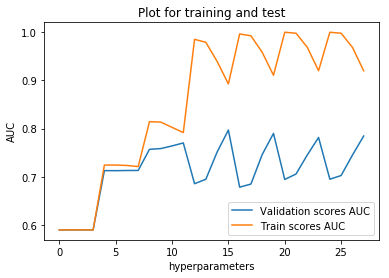

In [59]:
import math
plt.plot(cv_scores,label="Validation scores AUC")
plt.plot(train_scores,label="Train scores AUC")

plt.ylabel('AUC')
plt.xlabel('hyperparameters')
plt.title('Plot for training and test')
plt.legend()
plt.show()

# PLOTTING HEATMAP FOR VALIDATION

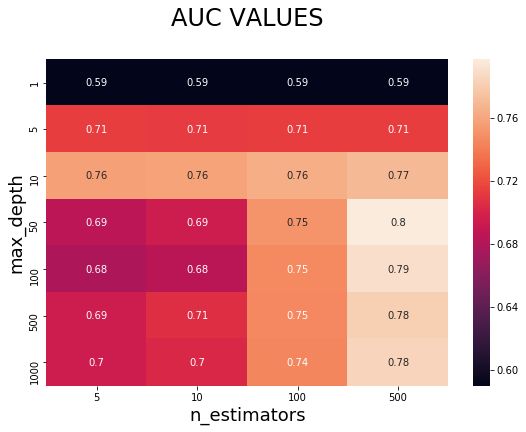

In [60]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= [1, 5, 10, 50, 100, 500,1000]
Cols = [5, 10, 100, 500]
df = DataFrame(data=cv_scores.reshape(7,4), index=Index, columns=Cols)
plt.figure(figsize=(9, 6))
heatmap=sns.heatmap(df, annot=True)

# Setting tick labels for heatmap
#heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
#heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('max_depth',size=18)
plt.xlabel('n_estimators',size=18)
plt.title("AUC VALUES\n",size=24)
plt.show()




# PLOTTING HEATMAP FOR TRAINING

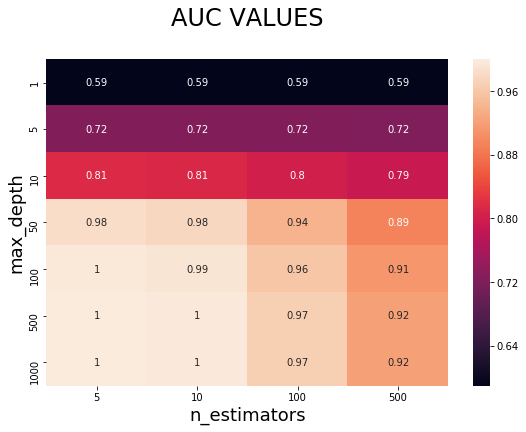

In [61]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= [1, 5, 10, 50, 100, 500,1000]
Cols = [5, 10, 100, 500]
df = DataFrame(data=train_scores.reshape(7,4), index=Index, columns=Cols)
plt.figure(figsize=(9, 6))
heatmap=sns.heatmap(df, annot=True)

# Setting tick labels for heatmap
#heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
#heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('max_depth',size=18)
plt.xlabel('n_estimators',size=18)
plt.title("AUC VALUES\n",size=24)
plt.show()


In [62]:

from sklearn.metrics import roc_auc_score
dtc = DecisionTreeClassifier(max_depth=best_depth,min_samples_split=best_split,class_weight ='balanced')
dtc.fit(bow_train,y_train)

predictions=dtc.predict(bow_test)

predictions1=dtc.predict_proba(bow_test)
predictions1_train=dtc.predict_proba(bow_train)

In [63]:
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
auc_final = roc_auc_score(y_test,predictions1[:,1])
fpr, tpr, thresholds = roc_curve(y_test, predictions1[:,1])
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train,predictions1_train[:,1])
print(auc_final)

0.8080538060192783


# PLOTTING ROC FOR TRAINING AND TEST

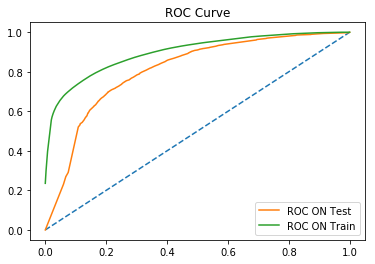

In [64]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr,label="ROC ON Test")
plt.plot(fpr_tr, tpr_tr,label="ROC ON Train")
plt.title('ROC Curve')
plt.legend()
plt.show()

# PLOTTING CONFUSION MATRIX

[[3414, 1143], [5727, 16048]]


,Predicted No,Predicted Yes
Actual No,3414,1143
Actual Yes,5727,16048


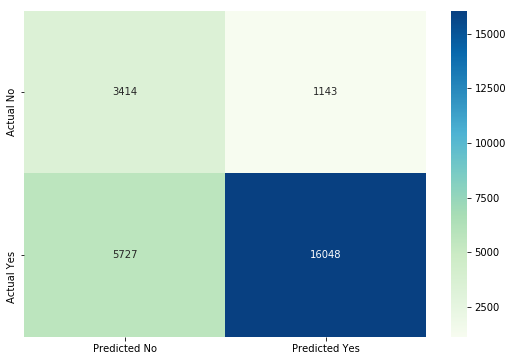

In [65]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[(tn), (fp)], [(fn), (tp)]]
print(array)
df_cm = pd.DataFrame(array, ['Actual No','Actual Yes'],
                  ['Predicted No','Predicted Yes'])
plt.figure(figsize=(9, 6))
sns.heatmap(df_cm, annot=True,fmt='d', cmap = "GnBu")
df_cm

# Top 20 features 

In [66]:
S=dtc.feature_importances_.argsort()[::-1]
M=dtc.feature_importances_[S]  
X=M[0:20]
feature_names=np.array(count_vect.get_feature_names())
L=feature_names[S]

Y=L[0:20]
O=pd.DataFrame({'features': Y,
 'score': X})
O





,features,score
0,great,0.108915
1,love,0.063566
2,disappoint,0.056765
3,best,0.045023
4,delici,0.038570
5,bad,0.037965
6,perfect,0.023984
7,favorit,0.022623
8,good,0.022158
9,thought,0.019830


# VISUALIZING TREE

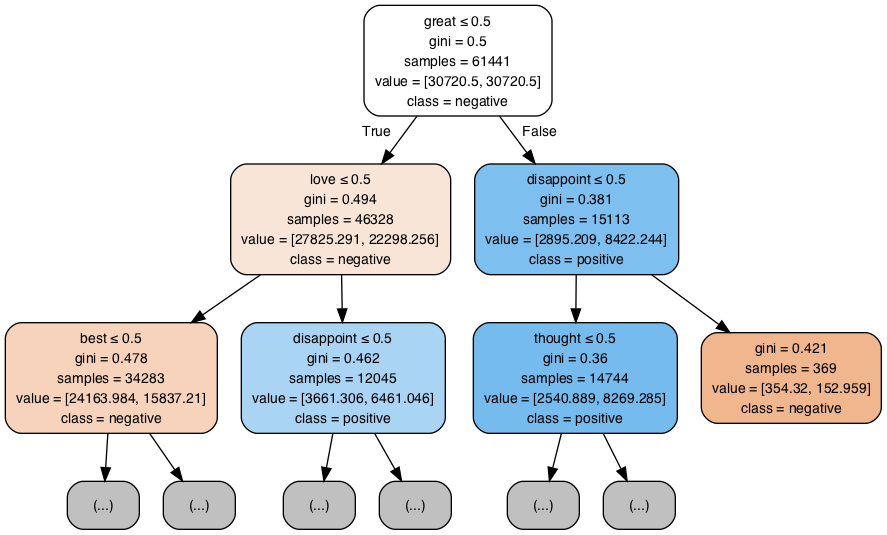

In [67]:
# Importing libraries
from sklearn import tree
import pydotplus
from IPython.display import Image
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
target = ['negative','positive']
# Create DOT data
data = tree.export_graphviz(dtc,out_file=None,class_names=target,filled=True,rounded=True,special_characters=True,max_depth=2,feature_names=count_vect.get_feature_names())

# Draw graph
graph = pydotplus.graph_from_dot_data(data)

# Show graph
Image(graph.create_png())



# [5.2] Applying decision tree on tf-idf

In [81]:
tuned_parameters = [{'max_depth': [1, 5, 10, 50, 100, 500, 1000],'min_samples_split': [5, 10, 100, 500]}]
#Using GridSearchCV
model = GridSearchCV(DecisionTreeClassifier(class_weight ='balanced'),tuned_parameters,scoring='roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(tfidf_train, y_train)


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}],
       pre_dispatch=2, refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

# BEST HYPERPARAMETERS

In [82]:
best_depth = model.best_params_['max_depth']
print(best_depth)
best_split=model.best_params_['min_samples_split']
print(best_split)

50
500


In [84]:
cv_scores  = model.cv_results_['mean_test_score']
train_scores  = model.cv_results_['mean_train_score']
cv_scores

array([0.58656151, 0.58656151, 0.58656151, 0.58656151, 0.70437095,
       0.70437095, 0.7056412 , 0.70581618, 0.75305219, 0.75225459,
       0.76027226, 0.76367387, 0.68759582, 0.69485462, 0.7476128 ,
       0.78595914, 0.69589171, 0.70390076, 0.73998081, 0.77578349,
       0.68550057, 0.68934302, 0.72115902, 0.75381253, 0.68213081,
       0.68739343, 0.72357968, 0.75321971])

# PLOTTING AUC

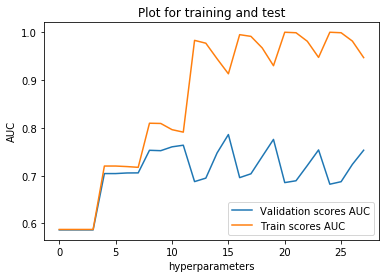

In [85]:
import math
plt.plot(cv_scores,label="Validation scores AUC")
plt.plot(train_scores,label="Train scores AUC")

plt.ylabel('AUC')
plt.xlabel('hyperparameters')
plt.title('Plot for training and test')
plt.legend()
plt.show()

# PLOTTING HEATMAP FOR VALIDATION

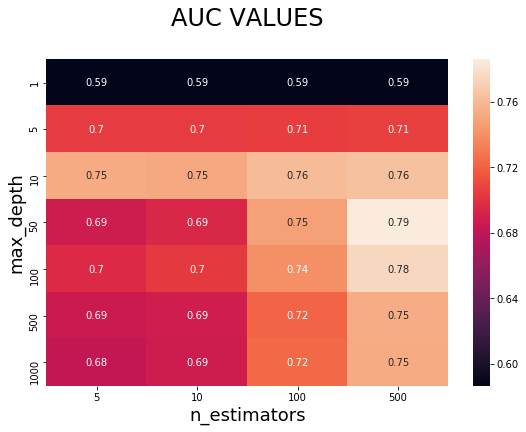

In [86]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= [1, 5, 10, 50, 100, 500,1000]
Cols = [5, 10, 100, 500]
df = DataFrame(data=cv_scores.reshape(7,4), index=Index, columns=Cols)
plt.figure(figsize=(9, 6))
heatmap=sns.heatmap(df, annot=True)

# Setting tick labels for heatmap
#heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
#heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('max_depth',size=18)
plt.xlabel('n_estimators',size=18)
plt.title("AUC VALUES\n",size=24)
plt.show()




# PLOTTING HEATMAP FOR TRAINING

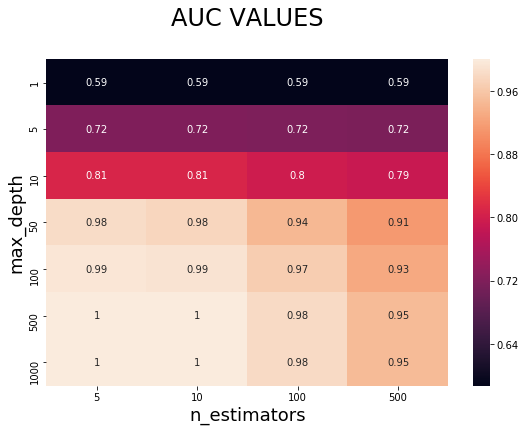

In [87]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= [1, 5, 10, 50, 100, 500,1000]
Cols = [5, 10, 100, 500]
df = DataFrame(data=train_scores.reshape(7,4), index=Index, columns=Cols)
plt.figure(figsize=(9, 6))
heatmap=sns.heatmap(df, annot=True)

# Setting tick labels for heatmap
#heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
#heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('max_depth',size=18)
plt.xlabel('n_estimators',size=18)
plt.title("AUC VALUES\n",size=24)
plt.show()


In [88]:
from sklearn.metrics import roc_auc_score
dtc = DecisionTreeClassifier(max_depth=best_depth,min_samples_split=best_split,class_weight ='balanced')
dtc.fit(tfidf_train,y_train)

predictions=dtc.predict(tfidf_test)
prediction_train=dtc.predict(tfidf_train)

predictions1=dtc.predict_proba(tfidf_test)
predictions1_train=dtc.predict_proba(tfidf_train)

In [89]:
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
tn1,fp1,fn1,tp1= confusion_matrix(y_train,prediction_train).ravel()
auc_final = roc_auc_score(y_test,predictions1[:,1])
fpr, tpr, thresholds = roc_curve(y_test, predictions1[:,1])
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train,predictions1_train[:,1])
print(auc_final)

0.7912444462248438


# PLOTTING ROC FOR TRAIN AND TEST

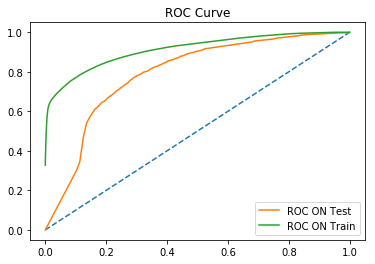

In [90]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr,label="ROC ON Test")
plt.plot(fpr_tr, tpr_tr,label="ROC ON Train")
plt.title('ROC Curve')
plt.legend()
plt.show()

# PLOTTING CO0NFUSION MATRIX FOR TEST

[[3324, 1233], [5586, 16189]]


,Predicted No,Predicted Yes
Actual No,3324,1233
Actual Yes,5586,16189


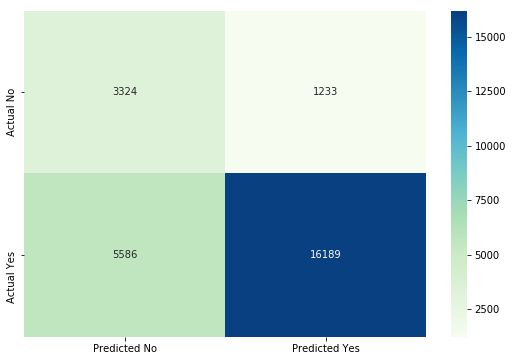

In [91]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[(tn), (fp)], [(fn), (tp)]]
print(array)
df_cm = pd.DataFrame(array, ['Actual No','Actual Yes'],
                  ['Predicted No','Predicted Yes'])
plt.figure(figsize=(9, 6))
sns.heatmap(df_cm, annot=True,fmt='d', cmap = "GnBu")
df_cm

# PLOTTING CONFUSION MATRIX FOR TRAIN

[[8647, 977], [11799, 40018]]


,Predicted No,Predicted Yes
Actual No,8647,977
Actual Yes,11799,40018


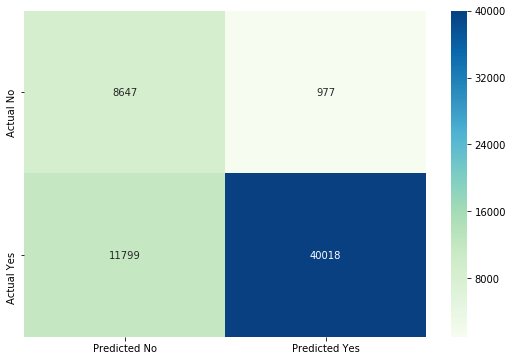

In [92]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[(tn1), (fp1)], [(fn1), (tp1)]]
print(array)
df_cm = pd.DataFrame(array, ['Actual No','Actual Yes'],
                  ['Predicted No','Predicted Yes'])
plt.figure(figsize=(9, 6))
sns.heatmap(df_cm, annot=True,fmt='d', cmap = "GnBu")
df_cm

# TOP 20 FEATURES

In [93]:
S=dtc.feature_importances_.argsort()[::-1]
M=dtc.feature_importances_[S]  
X=M[0:20]
feature_names=np.array(tfidf_vect.get_feature_names())
L=feature_names[S]

Y=L[0:20]
O=pd.DataFrame({'features': Y,
 'score': X})
O




,features,score
0,great,0.112259
1,love,0.072271
2,best,0.049488
3,disappoint,0.047207
4,delici,0.037796
5,good,0.026532
6,perfect,0.026149
7,bad,0.024909
8,favorit,0.019737
9,excel,0.017809


# VIZUALIZING TREE

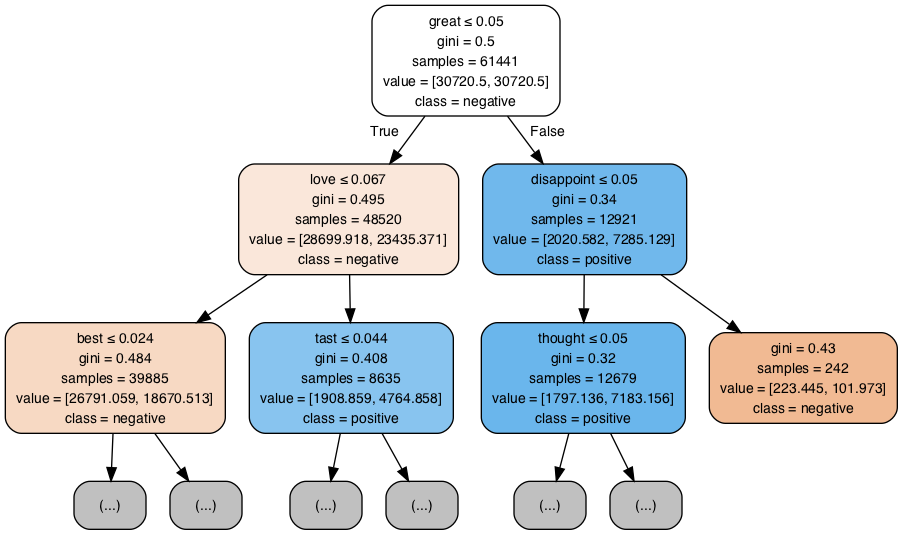

In [94]:
# Importing libraries
from sklearn import tree
import pydotplus
from IPython.display import Image
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
target = ['negative','positive']
# Create DOT data
data = tree.export_graphviz(dtc,out_file=None,class_names=target,filled=True,rounded=True,special_characters=True,max_depth=2,feature_names=tfidf_vect.get_feature_names())

# Draw graph
graph = pydotplus.graph_from_dot_data(data)

# Show graph
Image(graph.create_png())


# [5.3] APPLY DECISION TREE ON WORD2VEC

In [95]:
tuned_parameters = [{'max_depth': [1, 5, 10, 50, 100, 500, 1000],'min_samples_split': [5, 10, 100, 500]}]
#Using GridSearchCV
model = GridSearchCV(DecisionTreeClassifier(class_weight ='balanced'),tuned_parameters,scoring='roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(sent_vectors, y_train)


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}],
       pre_dispatch=2, refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

# BEST HYPERPARAMETERS

In [96]:
best_depth = model.best_params_['max_depth']
print(best_depth)
best_split=model.best_params_['min_samples_split']
print(best_split)

10
500


In [97]:
cv_scores  = model.cv_results_['mean_test_score']
train_scores  = model.cv_results_['mean_train_score']
cv_scores

array([0.66309013, 0.66309013, 0.66309013, 0.66309013, 0.79210173,
       0.79210173, 0.79210173, 0.79237534, 0.7646734 , 0.76689283,
       0.79672627, 0.8093609 , 0.65712561, 0.67204346, 0.77235007,
       0.80834865, 0.65573008, 0.67090013, 0.77284102, 0.80837431,
       0.65503302, 0.67080166, 0.77242865, 0.80851583, 0.6560957 ,
       0.67197575, 0.77332282, 0.80864855])

# PLOTTING AUC

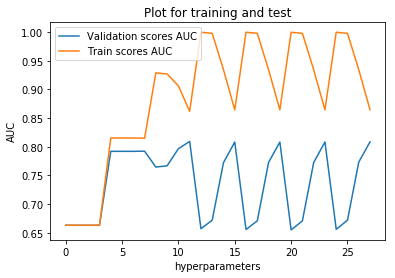

In [98]:
import math
plt.plot(cv_scores,label="Validation scores AUC")
plt.plot(train_scores,label="Train scores AUC")

plt.ylabel('AUC')
plt.xlabel('hyperparameters')
plt.title('Plot for training and test')
plt.legend()
plt.show()

# PLOTTING HEATMAP FOR VALIDATION

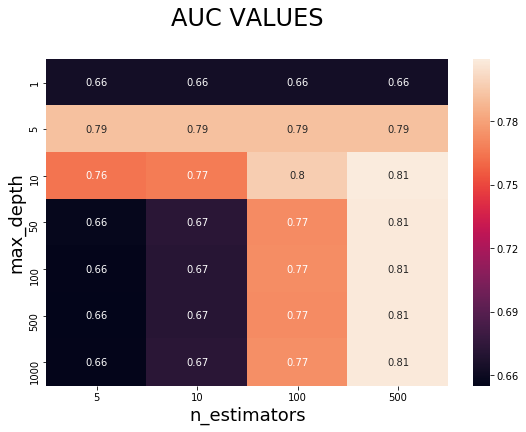

In [99]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= [1, 5, 10, 50, 100, 500,1000]
Cols = [5, 10, 100, 500]
df = DataFrame(data=cv_scores.reshape(7,4), index=Index, columns=Cols)
plt.figure(figsize=(9, 6))
heatmap=sns.heatmap(df, annot=True)

# Setting tick labels for heatmap
#heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
#heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('max_depth',size=18)
plt.xlabel('n_estimators',size=18)
plt.title("AUC VALUES\n",size=24)
plt.show()



# PLOTTING HEATMAP FOR TRAINING

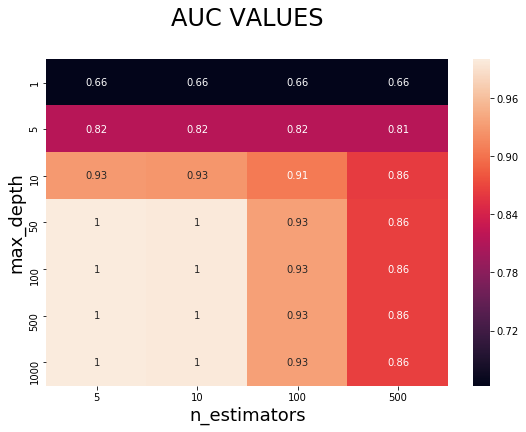

In [100]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= [1, 5, 10, 50, 100, 500,1000]
Cols = [5, 10, 100, 500]
df = DataFrame(data=train_scores.reshape(7,4), index=Index, columns=Cols)
plt.figure(figsize=(9, 6))
heatmap=sns.heatmap(df, annot=True)

# Setting tick labels for heatmap
#heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
#heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('max_depth',size=18)
plt.xlabel('n_estimators',size=18)
plt.title("AUC VALUES\n",size=24)
plt.show()


In [101]:
from sklearn.metrics import roc_auc_score
dtc = DecisionTreeClassifier(max_depth=best_depth,min_samples_split=best_split,class_weight ='balanced')
dtc.fit(sent_vectors,y_train)

predictions=dtc.predict(test_vectors)
prediction_train=dtc.predict(sent_vectors)

predictions1=dtc.predict_proba(test_vectors)
predictions1_train=dtc.predict_proba(sent_vectors)

In [102]:
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
tn1,fp1,fn1,tp1= confusion_matrix(y_train,prediction_train).ravel()
auc_final = roc_auc_score(y_test,predictions1[:,1])
fpr, tpr, thresholds = roc_curve(y_test, predictions1[:,1])
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train,predictions1_train[:,1])
print(auc_final)

0.8222682203506194


# PLOTTING ROC 

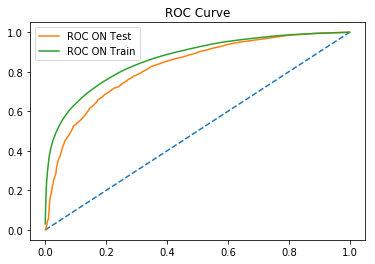

In [103]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr,label="ROC ON Test")
plt.plot(fpr_tr, tpr_tr,label="ROC ON Train")
plt.title('ROC Curve')
plt.legend()
plt.show()

# PLOTTING CONFUSION MATRIX FOR TEST

[[3424, 1133], [5766, 16009]]


,Predicted No,Predicted Yes
Actual No,3424,1133
Actual Yes,5766,16009


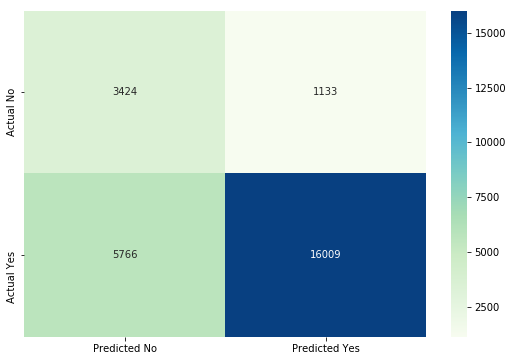

In [104]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[(tn), (fp)], [(fn), (tp)]]
print(array)
df_cm = pd.DataFrame(array, ['Actual No','Actual Yes'],
                  ['Predicted No','Predicted Yes'])
plt.figure(figsize=(9, 6))
sns.heatmap(df_cm, annot=True,fmt='d', cmap = "GnBu")
df_cm

# PLOTTING CONFUSION MATRIX FOR TRAIN

[[7801, 1823], [13016, 38801]]


,Predicted No,Predicted Yes
Actual No,7801,1823
Actual Yes,13016,38801


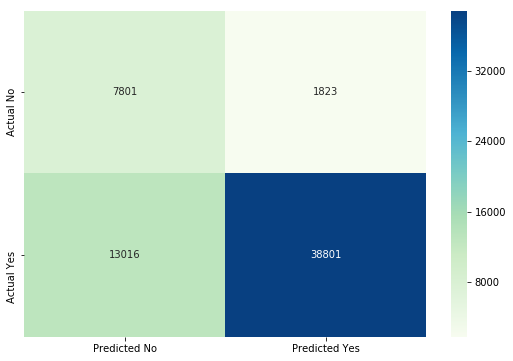

In [105]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[(tn1), (fp1)], [(fn1), (tp1)]]
print(array)
df_cm = pd.DataFrame(array, ['Actual No','Actual Yes'],
                  ['Predicted No','Predicted Yes'])
plt.figure(figsize=(9, 6))
sns.heatmap(df_cm, annot=True,fmt='d', cmap = "GnBu")
df_cm

# [5.4]APPLY DECISION TREE ON TFIDF-W2V

In [107]:
tuned_parameters = [{'max_depth': [1, 5, 10, 50, 100, 500, 1000],'min_samples_split': [5, 10, 100, 500]}]
#Using GridSearchCV
model = GridSearchCV(DecisionTreeClassifier(class_weight ='balanced'),tuned_parameters,scoring='roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec, y_train)


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}],
       pre_dispatch=2, refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [108]:
best_depth = model.best_params_['max_depth']
print(best_depth)
best_split=model.best_params_['min_samples_split']
print(best_split)

10
500


In [109]:
cv_scores  = model.cv_results_['mean_test_score']
train_scores  = model.cv_results_['mean_train_score']
cv_scores

array([0.63297067, 0.63297067, 0.63297067, 0.63297067, 0.75742913,
       0.75742913, 0.75742913, 0.75742913, 0.73381119, 0.73442535,
       0.75866828, 0.77704384, 0.63235773, 0.64327988, 0.73220846,
       0.77629184, 0.63435986, 0.64419494, 0.7325881 , 0.77605855,
       0.63145254, 0.64393419, 0.73243091, 0.77629184, 0.63294969,
       0.64491538, 0.73253921, 0.77629184])

# PLOTTING AUC

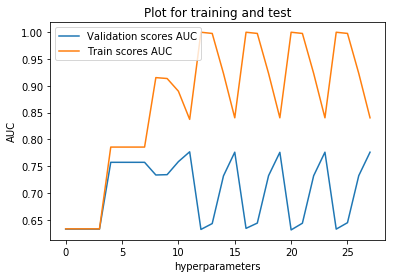

In [110]:
import math
plt.plot(cv_scores,label="Validation scores AUC")
plt.plot(train_scores,label="Train scores AUC")

plt.ylabel('AUC')
plt.xlabel('hyperparameters')
plt.title('Plot for training and test')
plt.legend()
plt.show()

# PLOTTING HEATMAP FOR VALIDATION

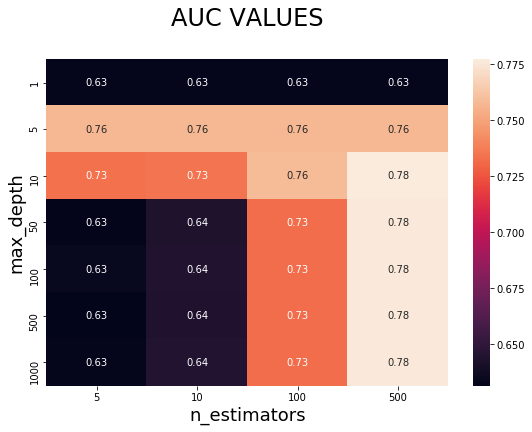

In [111]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= [1, 5, 10, 50, 100, 500,1000]
Cols = [5, 10, 100, 500]
df = DataFrame(data=cv_scores.reshape(7,4), index=Index, columns=Cols)
plt.figure(figsize=(9, 6))
heatmap=sns.heatmap(df, annot=True)

# Setting tick labels for heatmap
#heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
#heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('max_depth',size=18)
plt.xlabel('n_estimators',size=18)
plt.title("AUC VALUES\n",size=24)
plt.show()

# PLOTTING HEATMAP FOR TRAINING

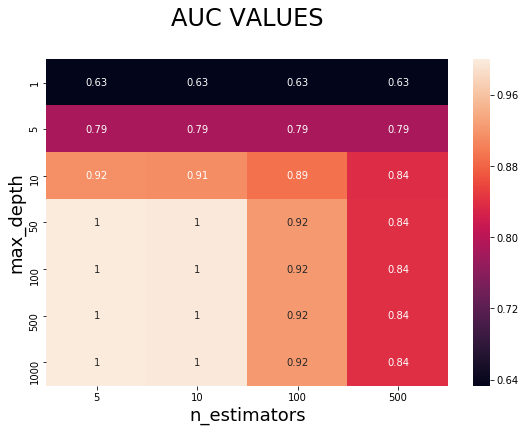

In [112]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= [1, 5, 10, 50, 100, 500,1000]
Cols = [5, 10, 100, 500]
df = DataFrame(data=train_scores.reshape(7,4), index=Index, columns=Cols)
plt.figure(figsize=(9, 6))
heatmap=sns.heatmap(df, annot=True)

# Setting tick labels for heatmap
#heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
#heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('max_depth',size=18)
plt.xlabel('n_estimators',size=18)
plt.title("AUC VALUES\n",size=24)
plt.show()


In [113]:
from sklearn.metrics import roc_auc_score
dtc = DecisionTreeClassifier(max_depth=best_depth,min_samples_split=best_split,class_weight ='balanced')
dtc.fit(X_train_vec,y_train)

predictions=dtc.predict(X_test_vec)
prediction_train=dtc.predict(X_train_vec)

predictions1=dtc.predict_proba(X_test_vec)
predictions1_train=dtc.predict_proba(X_train_vec)

In [116]:
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
tn1,fp1,fn1,tp1= confusion_matrix(y_train,prediction_train).ravel()
auc_final = roc_auc_score(y_test,predictions1[:,1])
fpr, tpr, thresholds = roc_curve(y_test, predictions1[:,1])
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train,predictions1_train[:,1])
print(auc_final)

0.5571184387980591


# PLOTTING ROC

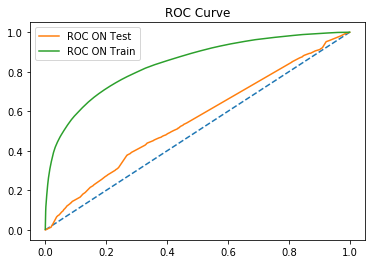

In [117]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr,label="ROC ON Test")
plt.plot(fpr_tr, tpr_tr,label="ROC ON Train")
plt.title('ROC Curve')
plt.legend()
plt.show()

# PLOTTING CONFUSION MATRIX FOR TEST

[[2824, 1733], [11563, 10212]]


,Predicted No,Predicted Yes
Actual No,2824,1733
Actual Yes,11563,10212


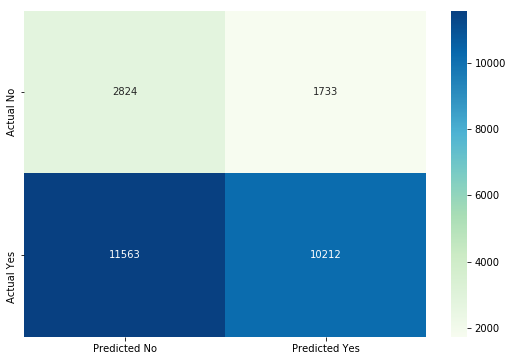

In [118]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[(tn), (fp)], [(fn), (tp)]]
print(array)
df_cm = pd.DataFrame(array, ['Actual No','Actual Yes'],
                  ['Predicted No','Predicted Yes'])
plt.figure(figsize=(9, 6))
sns.heatmap(df_cm, annot=True,fmt='d', cmap = "GnBu")
df_cm

# PLOTTING CONFUSION MATRIX FOR TRAIN

[[7700, 1924], [14777, 37040]]


,Predicted No,Predicted Yes
Actual No,7700,1924
Actual Yes,14777,37040


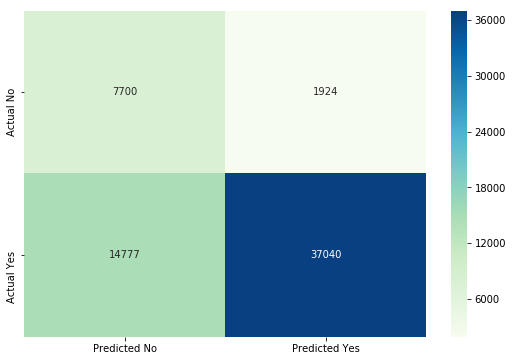

In [119]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[(tn1), (fp1)], [(fn1), (tp1)]]
print(array)
df_cm = pd.DataFrame(array, ['Actual No','Actual Yes'],
                  ['Predicted No','Predicted Yes'])
plt.figure(figsize=(9, 6))
sns.heatmap(df_cm, annot=True,fmt='d', cmap = "GnBu")
df_cm

# CONCLUSION

In [120]:
from prettytable import PrettyTable

    
x = PrettyTable()

x.field_names = ["Vectorizer", "Optimal_Depth","Optimal_Split","AUC"]

x.add_row(["BOW",50,500,0.808])
x.add_row(["TF-IDF",50,500,0.791])
x.add_row(["WORD2VEC",10,500,0.822])
x.add_row(["TFIDF-WORD2VEC",10,500,0.557])
print(x)


+----------------+---------------+---------------+-------+
|   Vectorizer   | Optimal_Depth | Optimal_Split |  AUC  |
+----------------+---------------+---------------+-------+
|      BOW       |       50      |      500      | 0.808 |
|     TF-IDF     |       50      |      500      | 0.791 |
|    WORD2VEC    |       10      |      500      | 0.822 |
| TFIDF-WORD2VEC |       10      |      500      | 0.557 |
+----------------+---------------+---------------+-------+
